# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import StratifiedKFold

data: pd.DataFrame = pd.read_csv('original.csv', sep=';')
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,False,582,False,20,True,265000.00,1.9,130,True,False,4,True
1,55.0,False,7861,False,38,False,263358.03,1.1,136,True,False,6,True
2,65.0,False,146,False,20,False,162000.00,1.3,129,True,True,7,True
3,50.0,True,111,False,20,False,210000.00,1.9,137,True,False,7,True
4,65.0,True,160,True,20,False,327000.00,2.7,116,False,False,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,False,61,True,38,True,155000.00,1.1,143,True,True,270,False
295,55.0,False,1820,False,38,False,270000.00,1.2,139,False,False,271,False
296,45.0,False,2060,True,60,False,742000.00,0.8,138,False,False,278,False
297,45.0,False,2413,False,38,False,140000.00,1.4,140,True,True,280,False


## 3.0. Training Models

---

### Training Models

---

#### StratifiedKFold function
After loading the data, in data dataframe, we need to separate the target variable which is the DEATH_EVENT from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves

In [2]:
target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

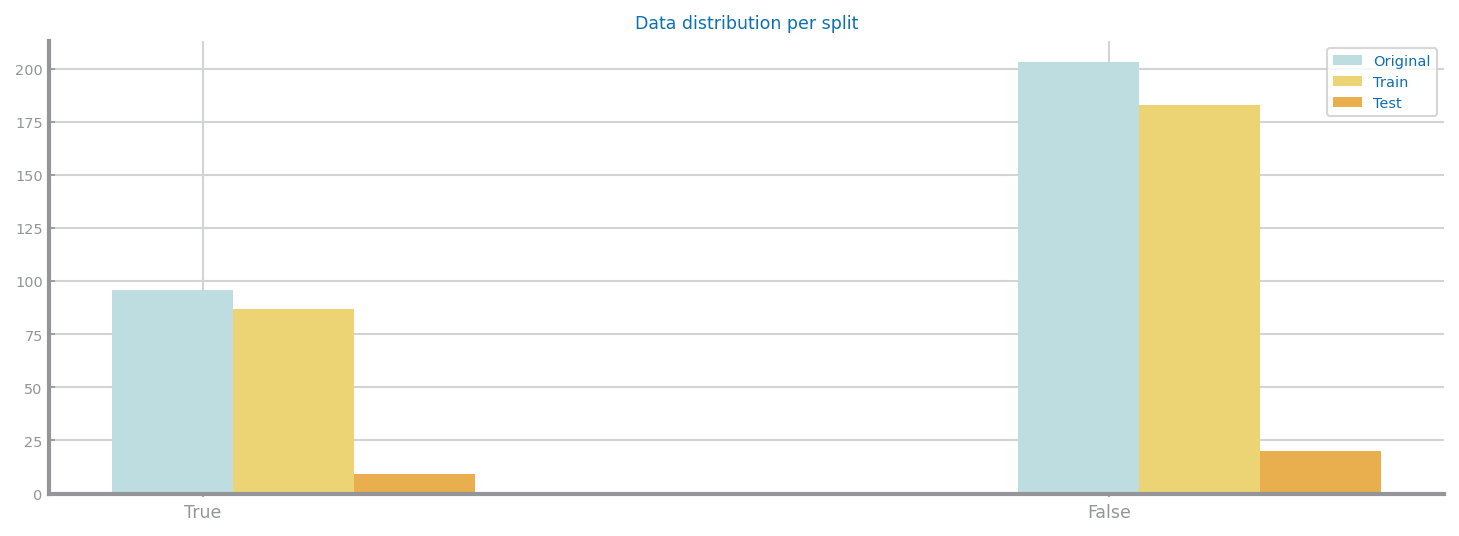

In [3]:
np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

We have just plotted the chart of one split because the splits have identical distribution which will make the bar charts equal.

## 3.3. Decision Trees

---

<Figure size 600x450 with 0 Axes>

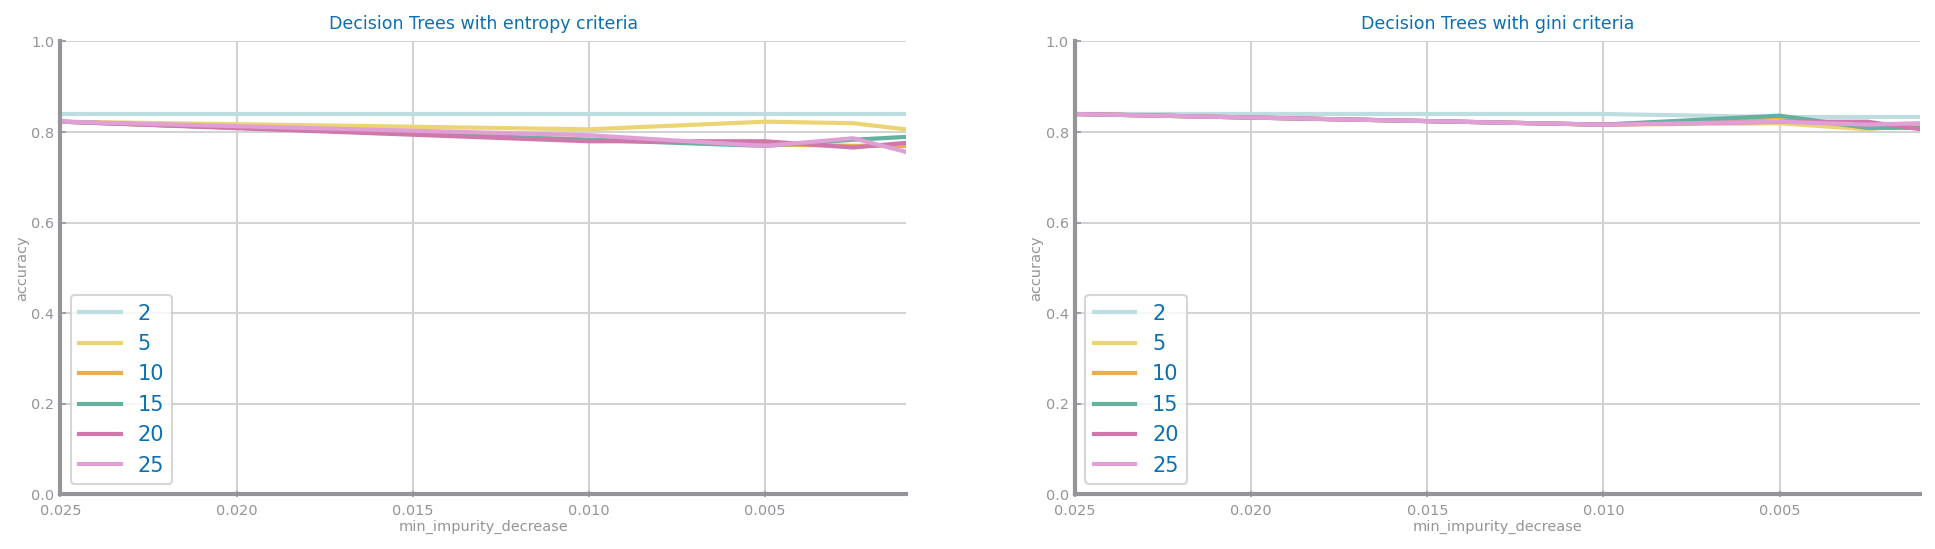

Best results achieved in split 8 with gini criteria, depth=10 and min_impurity_decrease=0.002500 ==> accuracy=0.966667
Best results per split:
	Split 0: entropy criteria, depth=5 and min_impurity_decrease=0.010000 ==> accuracy=0.766667
	Split 1: gini criteria, depth=10 and min_impurity_decrease=0.005000 ==> accuracy=0.766667
	Split 2: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.800000
	Split 3: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.933333
	Split 4: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.900000
	Split 5: entropy criteria, depth=5 and min_impurity_decrease=0.005000 ==> accuracy=0.933333
	Split 6: gini criteria, depth=15 and min_impurity_decrease=0.002500 ==> accuracy=0.866667
	Split 7: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.833333
	Split 8: gini criteria, depth=10 and min_impurity_decrease=0.002500 ==> accuracy=0.966667
	Split 9: entropy criteria

In [4]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']

best = ('',  0, 0.0) # (criteria, max depth, min impurity decrease)
best_tree = None
last_best = 0 # accuracy
best_split = None
best_spli = 0

NUM_SPLITS = len(splits)
split_best = [('',  0, 0.0)] * NUM_SPLITS
split_best_tree = [None] * NUM_SPLITS
split_last_best = [0] * NUM_SPLITS

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        values[d] = []
        for i in range(len(min_impurity_decrease)):
            values[d].append(0)
    for spli in range(NUM_SPLITS):
        split = splits[spli]
        for d in max_depths:
            yvalues = []
            for imp in min_impurity_decrease:
                tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(split['X_train'], split['y_train'])
                split['prdY'] = tree.predict(split['X_test'])
                yvalues.append(metrics.accuracy_score(split['y_test'], split['prdY']))
                # Check if accuracy is better than best overall
                if yvalues[-1] > last_best:
                    best = (f, d, imp)
                    last_best = yvalues[-1]
                    best_tree = tree
                    best_split = split
                    best_spli = spli
                # Check if accuracy is better than best in current split
                if yvalues[-1] > split_last_best[spli]:
                    split_best[spli] = (f, d, imp)
                    split_last_best[spli] = yvalues[-1]
                    split_best_tree[spli] = tree
            # Increment total accuracy for current (max_depth, min_impurity decrease)
            for i in range(len(yvalues)):
                values[d][i] += yvalues[i]
    # Normalize
    for v in values:
        for i in range(len(values[v])):
            values[v][i] /= NUM_SPLITS
            
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
plt.show()
print('Best results achieved in split %d with %s criteria, depth=%d and min_impurity_decrease=%f ==> accuracy=%f'%(best_spli, best[0], best[1], best[2], last_best))

print('Best results per split:')
for i in range(len(splits)):
    print('\tSplit %d: %s criteria, depth=%d and min_impurity_decrease=%f ==> accuracy=%f' % (i, *split_best[i], split_last_best[i]))

In [5]:
from sklearn.tree import export_graphviz

for i in range(NUM_SPLITS):
    print("Split %d" % i)
    dot_data = export_graphviz(split_best_tree[i], out_file=('dtree%d.dot' % i) , filled=True, rounded=True, special_characters=True)
    # Convert to png
    from subprocess import call
    call(['dot', '-Tpng', 'dtree%d.dot' % i, '-o', 'dtree%d.png' % i, '-Gdpi=600'])

    plt.figure(figsize = (1.75 * split_best[i][1], 2.25 * split_best[i][1]))
    plt.imshow(plt.imread('dtree%d.png' % i))
    plt.axis('off')
    plt.show()

Split 0


KeyboardInterrupt: 

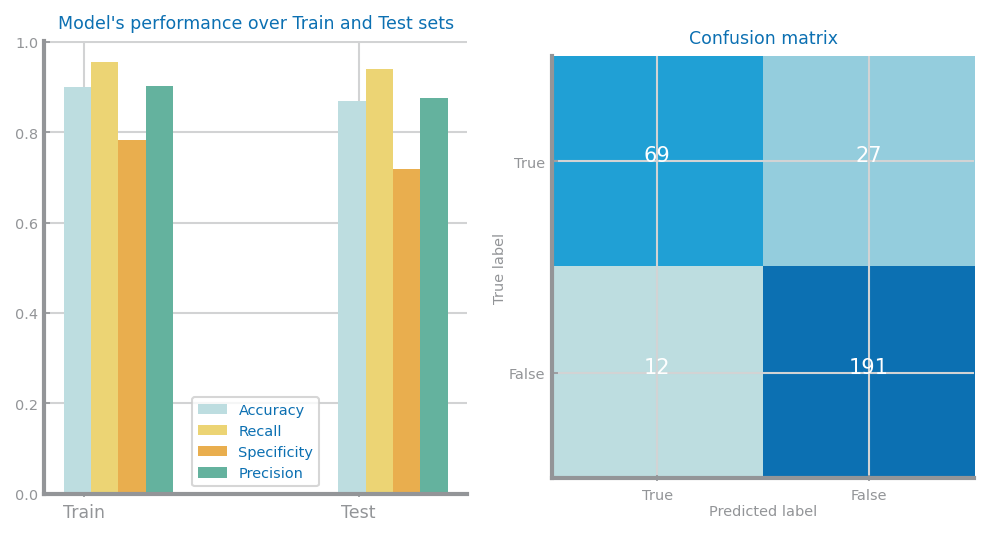

In [6]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(NUM_SPLITS):
    y_train_all.extend(splits[i]['y_train'])
    prd_train_all.extend(split_best_tree[i].predict(splits[i]['X_train']))
    y_test_all.extend(splits[i]['y_test'])
    prd_test_all.extend(split_best_tree[i].predict(splits[i]['X_test']))
    
ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

In [7]:
mean = np.mean(split_last_best)
std = np.std(split_last_best)
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print(f'Mean value: {round(mean, 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    minAcc = mean - t_st[c] * std / (10**0.5)
    maxAcc = mean + t_st[c] * std / (10**0.5)
    print(f'{int(conf*100)}% cofidence interval for accuracy: [' +
        f'{round(minAcc, 3)},{round(maxAcc, 3)}]')

Mean value: 0.87
95% cofidence interval for accuracy: [0.829,0.91]
99% cofidence interval for accuracy: [0.808,0.931]


### Overfitting study

<Figure size 600x450 with 0 Axes>

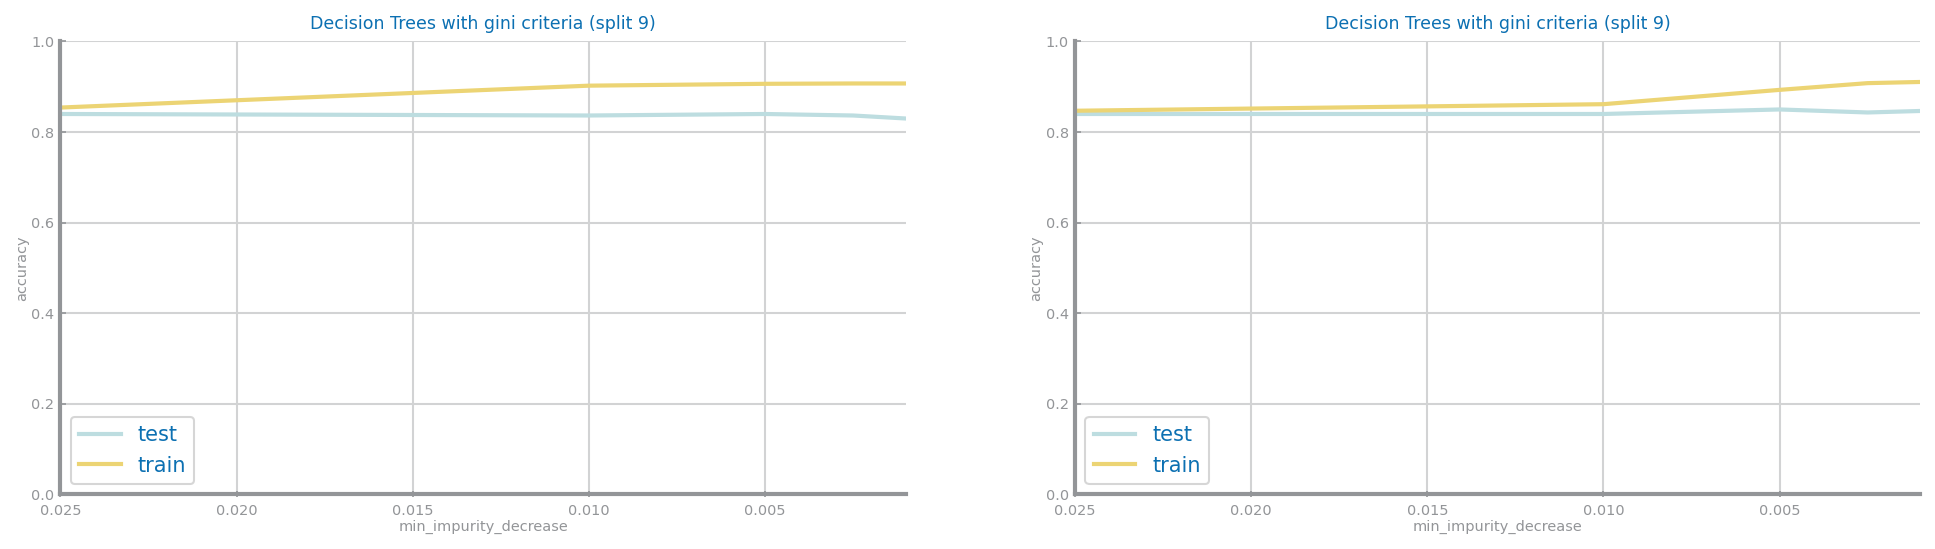

In [8]:
values = [{'test': [0 for _ in min_impurity_decrease], 
          'train': [0 for _ in min_impurity_decrease]}
          ,
          {'test': [0 for _ in min_impurity_decrease], 
          'train': [0 for _ in min_impurity_decrease]}
         ]

for i in range(NUM_SPLITS):
    d = split_best[i][1]
    
    for k in range(len(criteria)):
        f = criteria[k]
        
        yvalues = []
        yvalues_train = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(splits[i]['X_train'], splits[i]['y_train'])
            prdY = tree.predict(splits[i]['X_test'])
            prdY_train = tree.predict(splits[i]['X_train'])
            yvalues.append(metrics.accuracy_score(splits[i]['y_test'], prdY))
            yvalues_train.append(metrics.accuracy_score(splits[i]['y_train'], prdY_train))
        values[k]['test'] = [values[k]['test'][v] + 
            yvalues[v]/NUM_SPLITS for v in range(len(yvalues))]
        values[k]['train'] = [values[k]['train'][v] +
            yvalues_train[v]/NUM_SPLITS for v in range(len(yvalues_train))]

plt.figure()
fig, axs = plt.subplots(1, len(criteria), figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    ds.multiple_line_chart(min_impurity_decrease, values[k], ax=axs[0, k], title='Decision Trees with %s criteria (split %d)'%(f, i),
        xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
plt.show()

### Summary

---

- ***How do models improve with the increase of max_depth?***

Overall, they tend to decrease accuracy. 2 seems to be the most consistent best value for depth, even though 5 and 10 were the best depths for some splits

- ***How does performance change with decrease of min_impurity_decrease?***

Performance decreases with the decrease of min_impurity_decrease for all depths except 2 that stays the same.

- ***How do different criteria impact the model performance?***

Entropy achieves the best results when dealing with higher min_impurity_decrease but as we decrease it, gini performance decreases slower than entropy's.

- ***What is the best parametrisation (criteria, max_depth and min_impurity_decrease)?***

Best results achieved in split 8 with gini criteria, depth=10 and min_impurity_decrease=0.005000 ==> accuracy=0.966667

- ***Is the accuracy achieved good enough?***

Yes, althought there might be overfitting.

- ***What is the largest kind of errors?***

Most of the times there are no errors, but when there are is always one false negative.

- ***Is it possible to identify overfitting?***

Most of the times **no**, test accuracy is better than train accuracy, even when we decrease min_impurity_decrease (when using the best depth).